In [1]:
import os
import random
import warnings

# Our numerical workhorses
import numpy as np
import scipy.stats as st

import scipy
import scipy.ndimage
import scipy.ndimage.morphology

# BE/Bi 103 utilities
import sys
sys.path.insert(0, '/Users/Rusty/Desktop/bebi103_utils')
sys.path.append ('/Users/seinchin/Documents/Caltech/Bi 103/bebi103_utils')

import bebi103

import pandas as pd

# Image processing tools
import skimage.io
import skimage.filters
import skimage.morphology
import skimage.feature

# Import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline (only use with static plots (non-Bokeh))
# SVG is preferred, but there is a bug in Jupyter with vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# 1 A

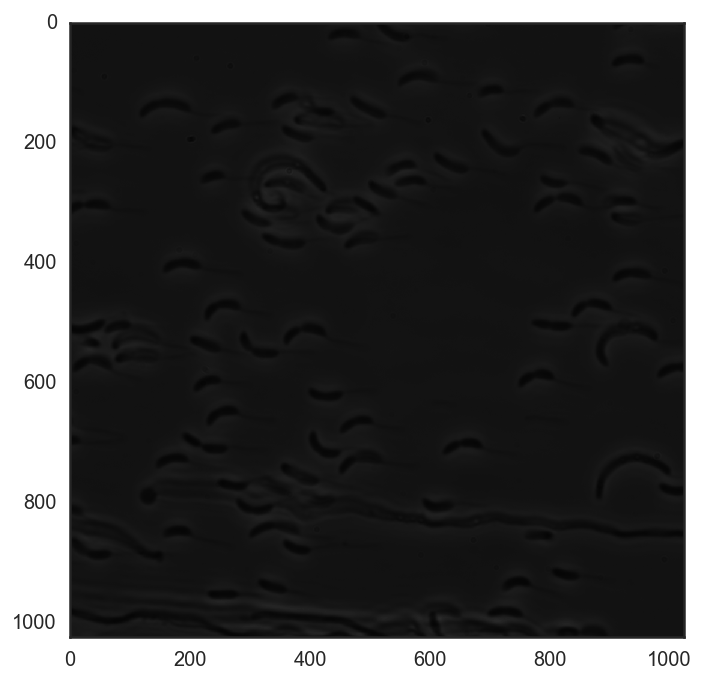

In [3]:
data_dir = 'data/hw8_iyer-biswas_et_al/sequential_full_field/'

# Define file name
fname = os.path.join(data_dir, 'phase03000.tif')

# Load the image
im = skimage.io.imread(fname)

# Take a look
with sns.axes_style('white'):
    skimage.io.imshow(im)

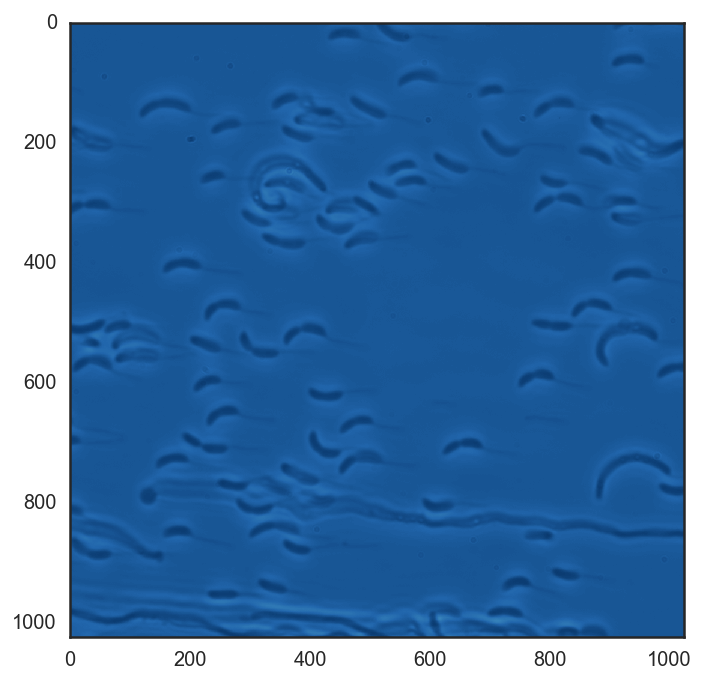

In [4]:
# This just looks black to me.  I'll try another color scheme
with sns.axes_style('white'):
    skimage.io.imshow(im, cmap=plt.cm.RdBu_r)


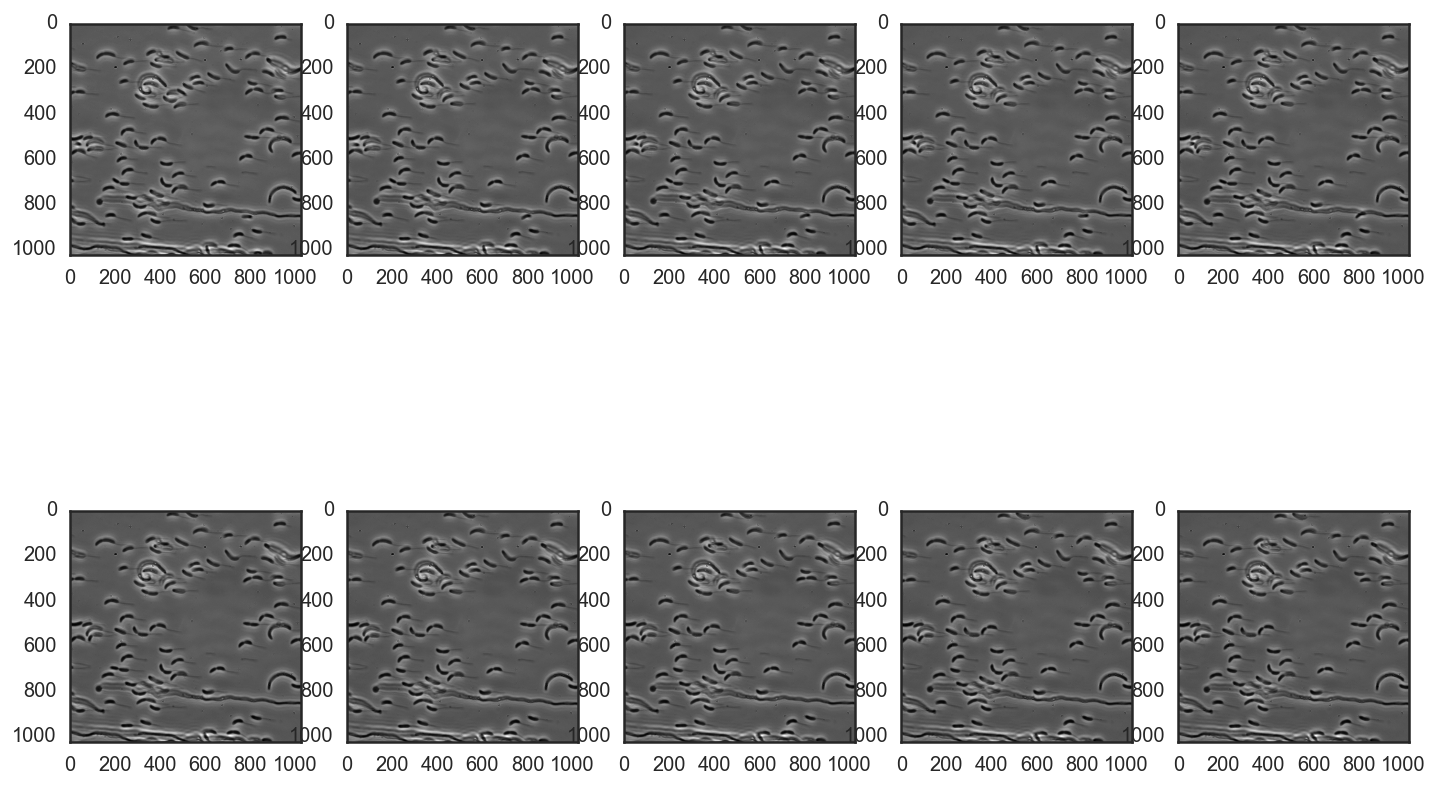

In [5]:
# Load all 10 images

fname_0 = os.path.join(data_dir, 'phase03000.tif')
fname_1 = os.path.join(data_dir, 'phase03001.tif')
fname_2 = os.path.join(data_dir, 'phase03002.tif')
fname_3 = os.path.join(data_dir, 'phase03003.tif')
fname_4 = os.path.join(data_dir, 'phase03004.tif')
fname_5 = os.path.join(data_dir, 'phase03005.tif')
fname_6 = os.path.join(data_dir, 'phase03006.tif')
fname_7 = os.path.join(data_dir, 'phase03007.tif')
fname_8 = os.path.join(data_dir, 'phase03008.tif')
fname_9 = os.path.join(data_dir, 'phase03009.tif')

ims = [skimage.io.imread(fname_0),
       skimage.io.imread(fname_1),
       skimage.io.imread(fname_2),
       skimage.io.imread(fname_3),
       skimage.io.imread(fname_4),
       skimage.io.imread(fname_5),
       skimage.io.imread(fname_6),
       skimage.io.imread(fname_7),
       skimage.io.imread(fname_8),
       skimage.io.imread(fname_9)]

# Say which images go in which subplots
im_sp = [(0,0), (0,1), (0,2), (0,3), (0,4), (1,0), (1,1), (1,2), (1,3), (1,4)]

# Display images
with sns.axes_style('white'):
    fig, ax = plt.subplots(2, 5, figsize=(12, 8))
    for i in range(10):
        ax[im_sp[i]].imshow(ims[i], cmap=plt.cm.gray)


       


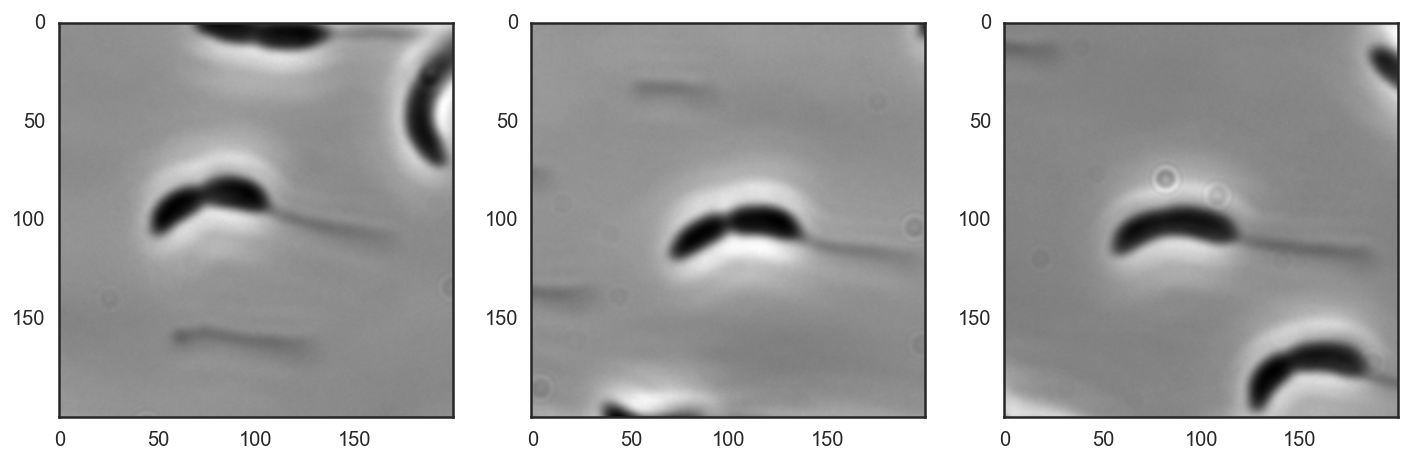

In [6]:
# Bacteria do not change position substantially in these pictures, 
# so it's ok to choose bacteria to segment based on just one picture.
# For easy segmentation, we should choose bacteria that are separated from the others
# and not near the crap at the bottom of the image

# Here are three good cantidates

with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 3, figsize=(12,5))
    ax[0].imshow(im[500:700, 700:900], cmap=plt.cm.gray)
    ax[1].imshow(im[600:800, 550:750], cmap=plt.cm.gray)
    ax[2].imshow(im[300:500, 100:300], cmap=plt.cm.gray)


//anaconda/lib/python3.4/site-packages/skimage/filters/rank/generic.py:68: UserWarning: Bitdepth of 13 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)


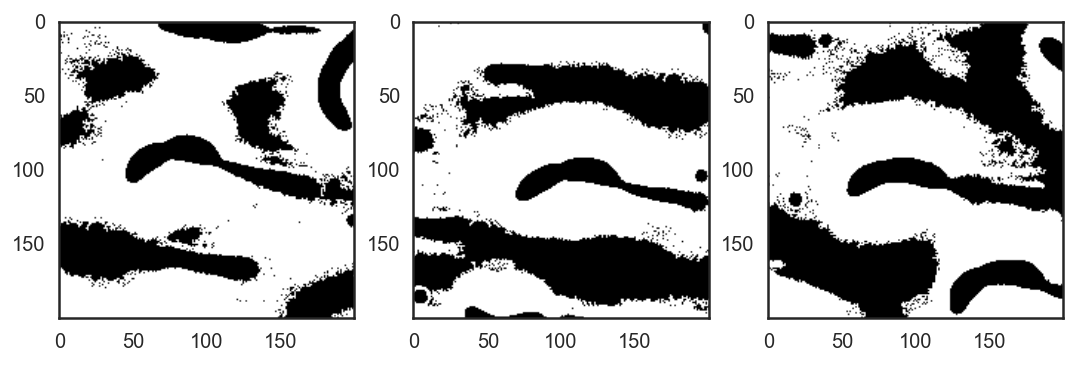

In [7]:
# Thresholding segmentation

def bebi103_thresh(im, selem, white_true=True, k_range=(0.5, 1.5), 
                   min_size=100):
    """
    Threshold image as described above.  Morphological mean filter is 
    applied using selem.
    """
    
    # Determine comparison operator
    if white_true:
        compare = np.greater
        sign = -1
    else:
        compare = np.less
        sign = 1
    
    # Do the mean filter
    im_mean = skimage.filters.rank.mean(im, selem)

    # Compute number of pixels in binary image as a function of k
    k = np.linspace(k_range[0], k_range[1], 100)
    n_pix = np.empty_like(k)
    for i in range(len(k)):
        n_pix[i] = compare(im, k[i] * im_mean).sum() 

    # Compute rough second derivative
    dn_pix_dk2 = np.diff(np.diff(n_pix))

    # Find index of maximal second derivative
    max_ind = np.argmax(sign * dn_pix_dk2)

    # Use this index to set k
    k_opt = k[max_ind - sign * 2]

    # Threshold with this k
    im_bw = compare(im, k_opt * im_mean)

    # Remove all the small objects
    im_bw = skimage.morphology.remove_small_objects(im_bw, min_size=min_size)
   
    return im_bw, k_opt

# Make the structuring element 50 pixel radius disk
selem = skimage.morphology.disk(50)

# Threshhold based on mean filter
im_bw, k = bebi103_thresh(im, selem, white_true=True, min_size=400)

# Show image
with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 3, figsize=(9,5))
    ax[0].imshow(im_bw[500:700, 700:900], cmap=plt.cm.gray)
    ax[1].imshow(im_bw[600:800, 550:750], cmap=plt.cm.gray)
    ax[2].imshow(im_bw[300:500, 100:300], cmap=plt.cm.gray)

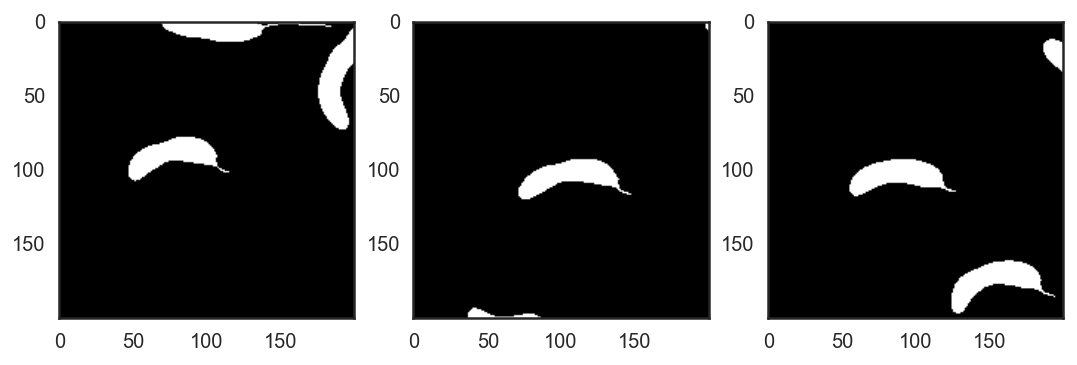

In [8]:
# That's pretty ugly, but you can see the bacteria
# Let's try Canny Edge Detection

im_float = ((im.astype(float) - im.min()) / (im.max() - im.min()))
im_edge = skimage.feature.canny(im_float, 2)

selem = skimage.morphology.disk(5)
im_edge_closed = skimage.morphology.binary_closing(im_edge, selem)

im_bw = scipy.ndimage.morphology.binary_fill_holes(im_edge_closed)

with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 3, figsize=(9,5))
    ax[0].imshow(im_bw[500:700, 700:900], cmap=plt.cm.gray)
    ax[1].imshow(im_bw[600:800, 550:750], cmap=plt.cm.gray)
    ax[2].imshow(im_bw[300:500, 100:300], cmap=plt.cm.gray)

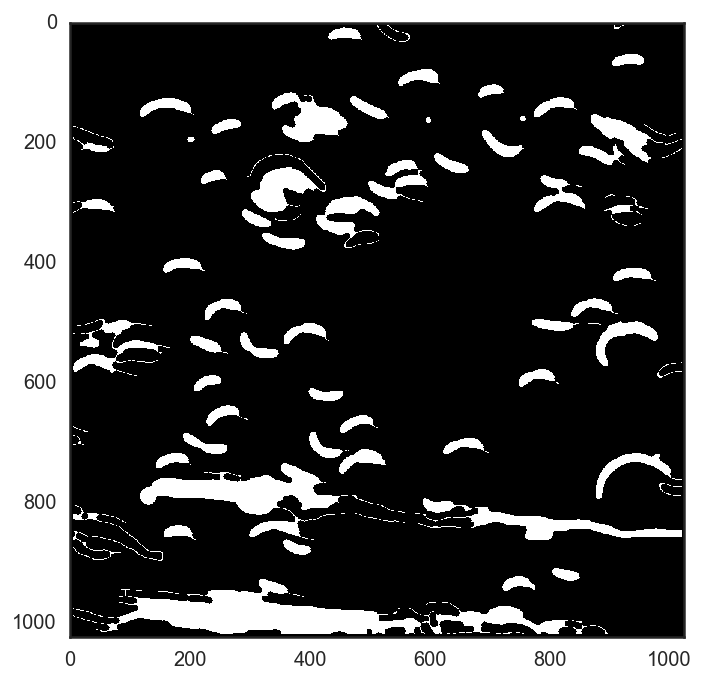

In [9]:
# Looks awesome for these bacteria
# Does the whole image look good, or, did we just choose easy bacteria?

with sns.axes_style('white'):
    skimage.io.imshow(im_bw, cmap=plt.cm.gray)

Nope, the whole image doesn't look pretty.  As I predicted, bacteria that are close to each other, and bacteria near the crap at the bottom of the image were harder to segment, but the three bacteria I chose look awesome.

# 1 B

In [10]:
data_dir = 'data/hw8_iyer-biswas_et_al/'

# Define file name
bac1 = os.path.join(data_dir, 'bacterium_1.tif')
bac2 = os.path.join(data_dir, 'bacterium_2.tif')

im_bac1 = skimage.io.imread(bac1)
im_bac2 = skimage.io.imread(bac2)

print(im_bac1.shape, im_bac2.shape)

(1900, 100, 150) (8700, 100, 300)


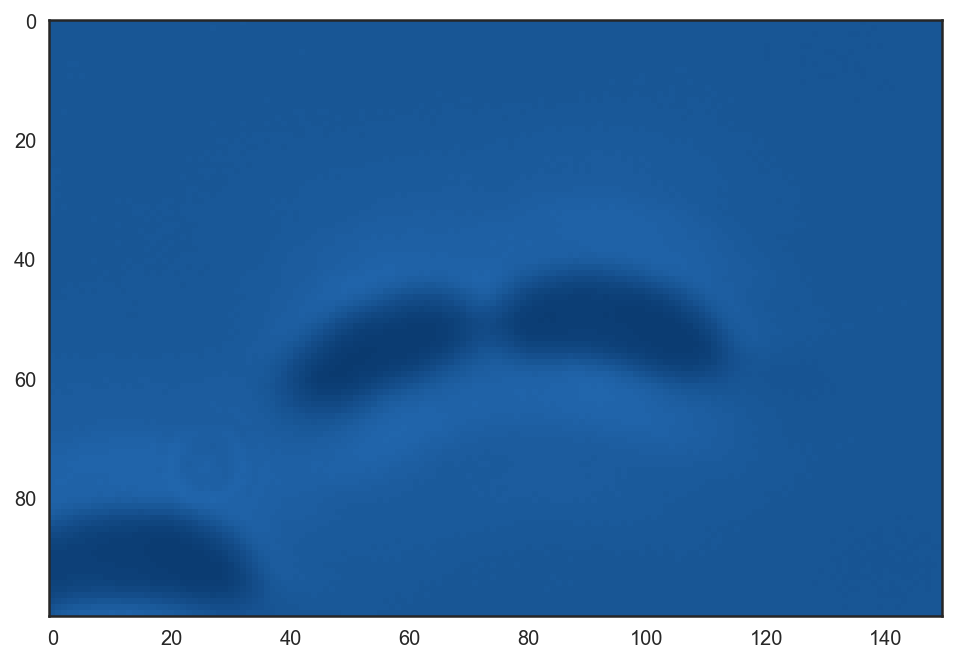

In [11]:
# There are 1900 images for Bac 1 and 8700 for Bac 2

im_bac1_0 = im_bac1[0,:,:]

with sns.axes_style('white'):
    skimage.io.imshow(im_bac1_0, cmap=plt.cm.RdBu_r)

In [12]:
# Bac1
g = 1900
bac1_bw = np.empty_like(im_bac1)

for p in range(g):
    im = im_bac1[p,:,:]
    im_float = ((im.astype(float) - im.min()) / (im.max() - im.min()))
    im_edge = skimage.feature.canny(im_float, 2)

    selem = skimage.morphology.disk(4)
    im_edge_closed = skimage.morphology.binary_closing(im_edge, selem)

    im_bw = scipy.ndimage.morphology.binary_fill_holes(im_edge_closed)
    
    bac1_bw[p,:,:] = im_bw



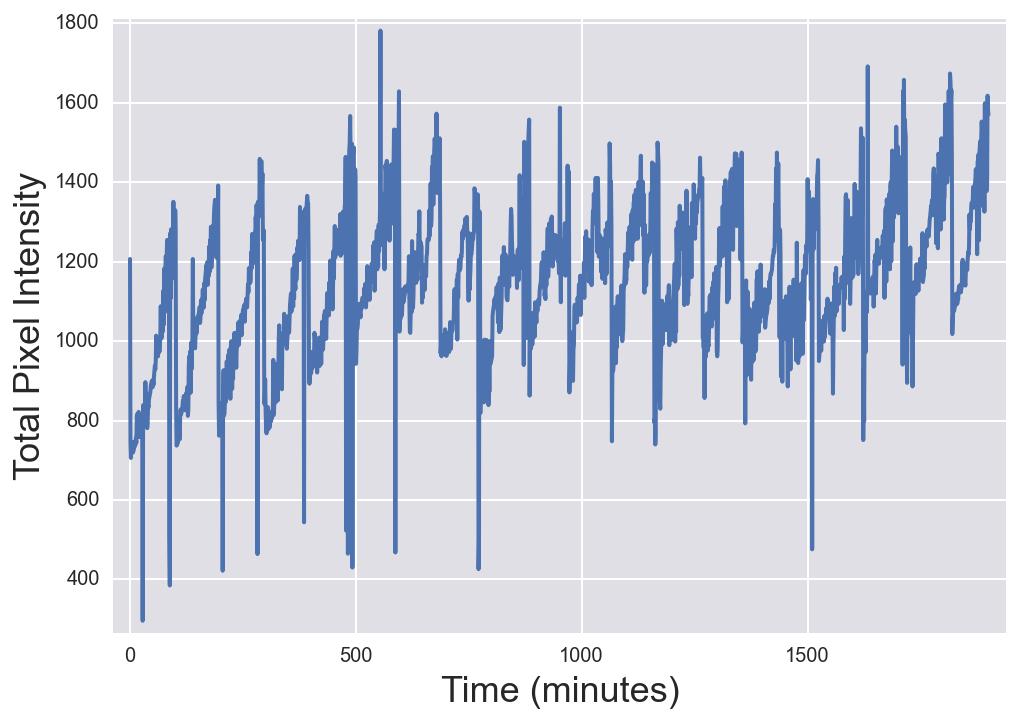

In [13]:
bac1_int = np.zeros(g)
for p in range(g):
    bac1_int[p] = bac1_bw[p,:,:].sum()

t = np.linspace(0,1900,num=1900)

plt.plot(t, bac1_int)
plt.xlabel('Time (minutes)')
plt.ylabel('Total Pixel Intensity')
plt.margins(0.02)

I count 20 periods of growth, follwed by division.  
Over 1900 minutes, that means the approximate time between divisions is 95 minutes


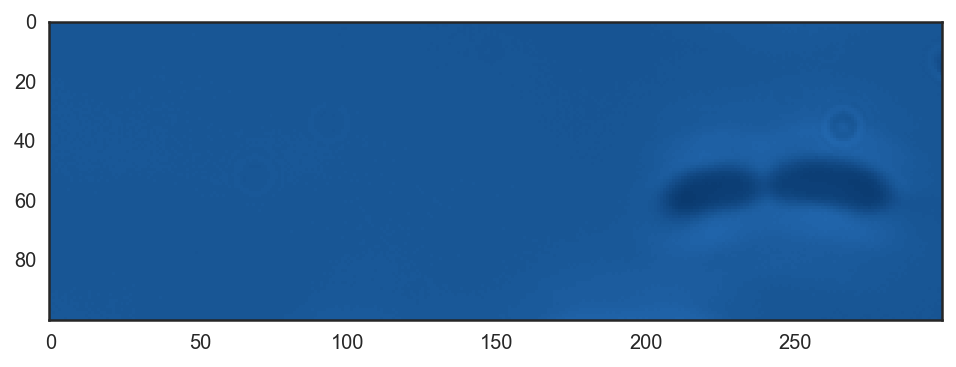

In [14]:
# Bac 2
im_bac2_0 = im_bac2[0,:,:]

with sns.axes_style('white'):
    skimage.io.imshow(im_bac2_0, cmap=plt.cm.RdBu_r)

In [53]:
# Bac2
q = 8700
bac2_bw = np.empty_like(im_bac2)

for p in range(q):
    im = im_bac2[p,:,:]
    im_float = ((im.astype(float) - im.min()) / (im.max() - im.min()))
    im_edge = skimage.feature.canny(im_float, 1)
    # This number has to be pretty high, otherwise I get bacteria that are not filled in.  
    # Better to err on the side of too much filled in than have some that are not filled in at all.
    selem = skimage.morphology.disk(5)
    im_edge_closed = skimage.morphology.binary_closing(im_edge, selem)

    im_bw = scipy.ndimage.morphology.binary_fill_holes(im_edge_closed)
    
    bac2_bw[p,:,:] = im_bw


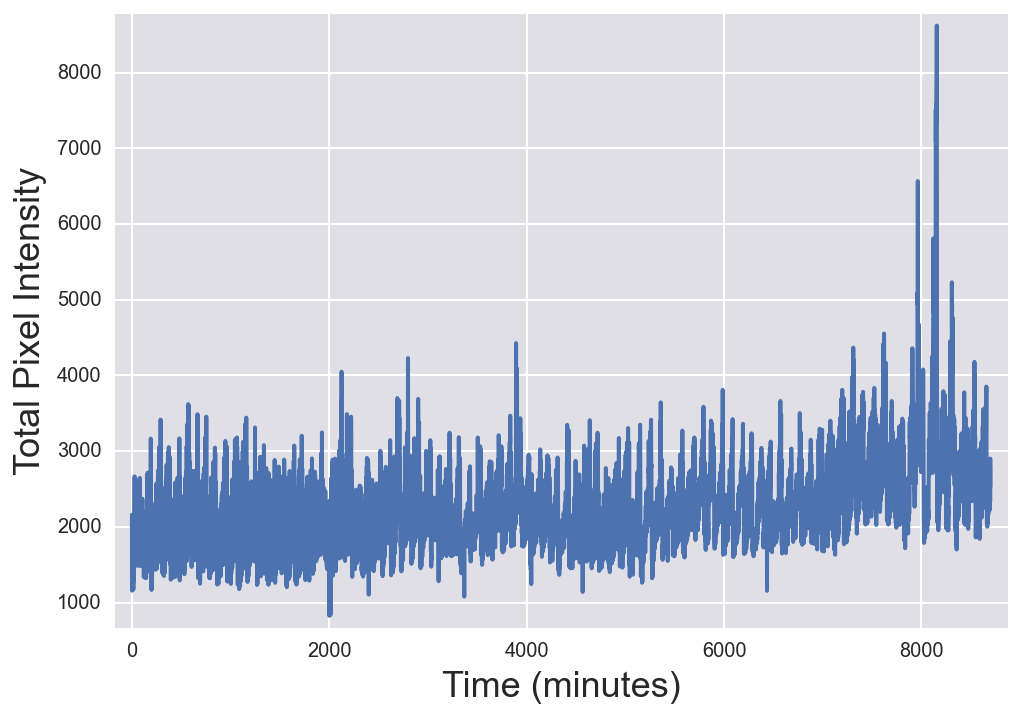

In [54]:
#Calculate the intensity over time
    
bac2_int = np.zeros(q)
for p in range(q):
    bac2_int[p] = bac2_bw[p,:,:].sum()

t = np.linspace(0,q,num=q)

plt.plot(t, bac2_int)
plt.xlabel('Time (minutes)')
plt.ylabel('Total Pixel Intensity')
plt.margins(0.02)

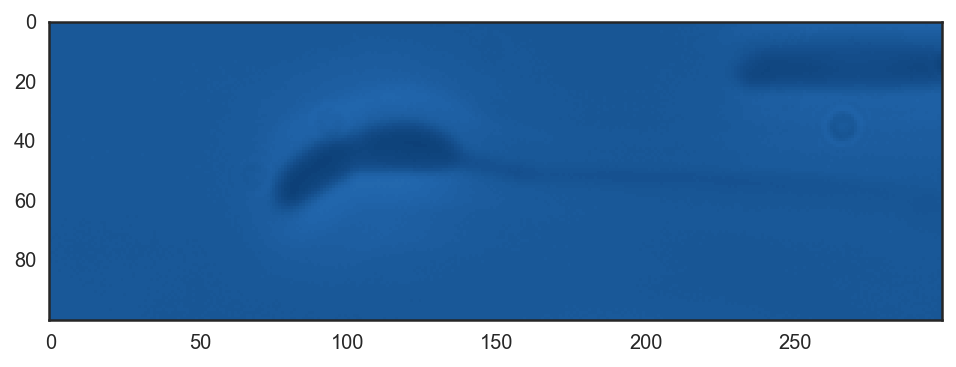

In [55]:
# What's going on at the 8000 minute mark?

with sns.axes_style('white'):
    skimage.io.imshow(im_bac2[8100,:,:], cmap=plt.cm.RdBu_r)

There are two bacteria now. This time course is much longer than the first one, so I say we throw out the frames with two bacteria, and we'll still have plenty of data.  

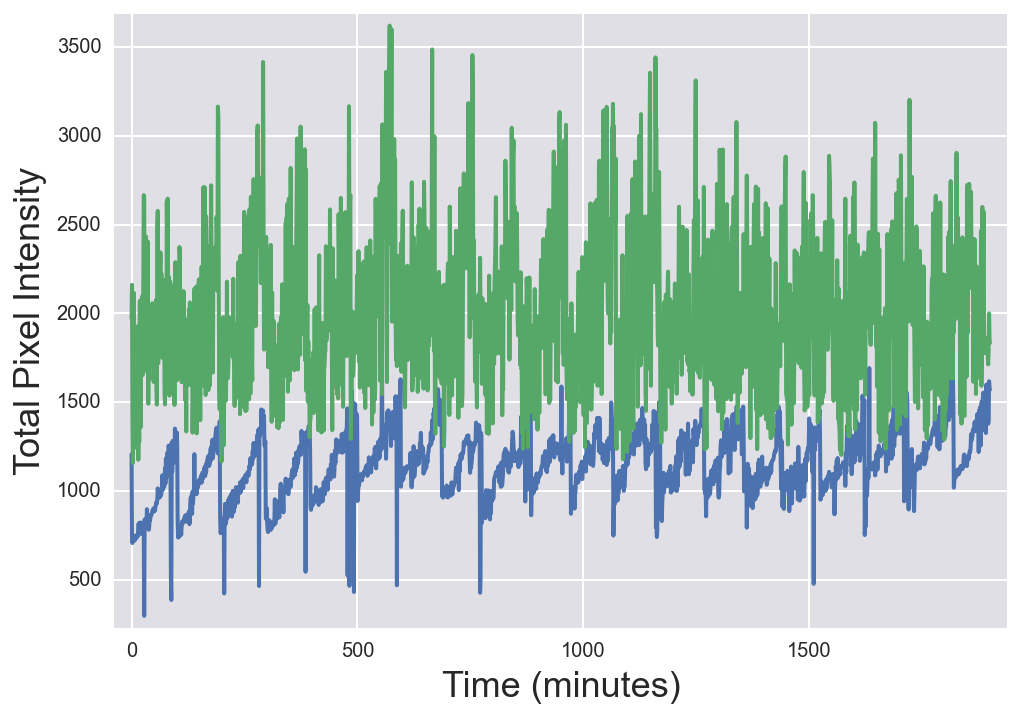

In [56]:
# Compare the two bacteria
t = np.linspace(0,g,num=g)

plt.plot(t, bac1_int[0:g])
plt.plot(t, bac2_int[0:g])
plt.xlabel('Time (minutes)')
plt.ylabel('Total Pixel Intensity')
plt.margins(0.02)

## Prob 8.1c. Model selection

Let's begin by using skimage.measure.regioprops to get the cell areas. We also want to make sure there's never more than one cell in the frame, which we can do by making sure the regionprop objects are all of length one. 

In [57]:
import skimage.measure
props = [skimage.measure.regionprops(bac1_bw[i,:,:]) for i in range(g)]
ncells = [len(p) for p in props]
area1 = [p[0].area for p in props]
print ((np.array(ncells)==1).all())
props = [skimage.measure.regionprops(bac2_bw[i,:,:]) for i in range(q)]
ncells = [len(p) for p in props]
area2 = [p[0].area for p in props]
print ((np.array(ncells)==1).all())

True
True


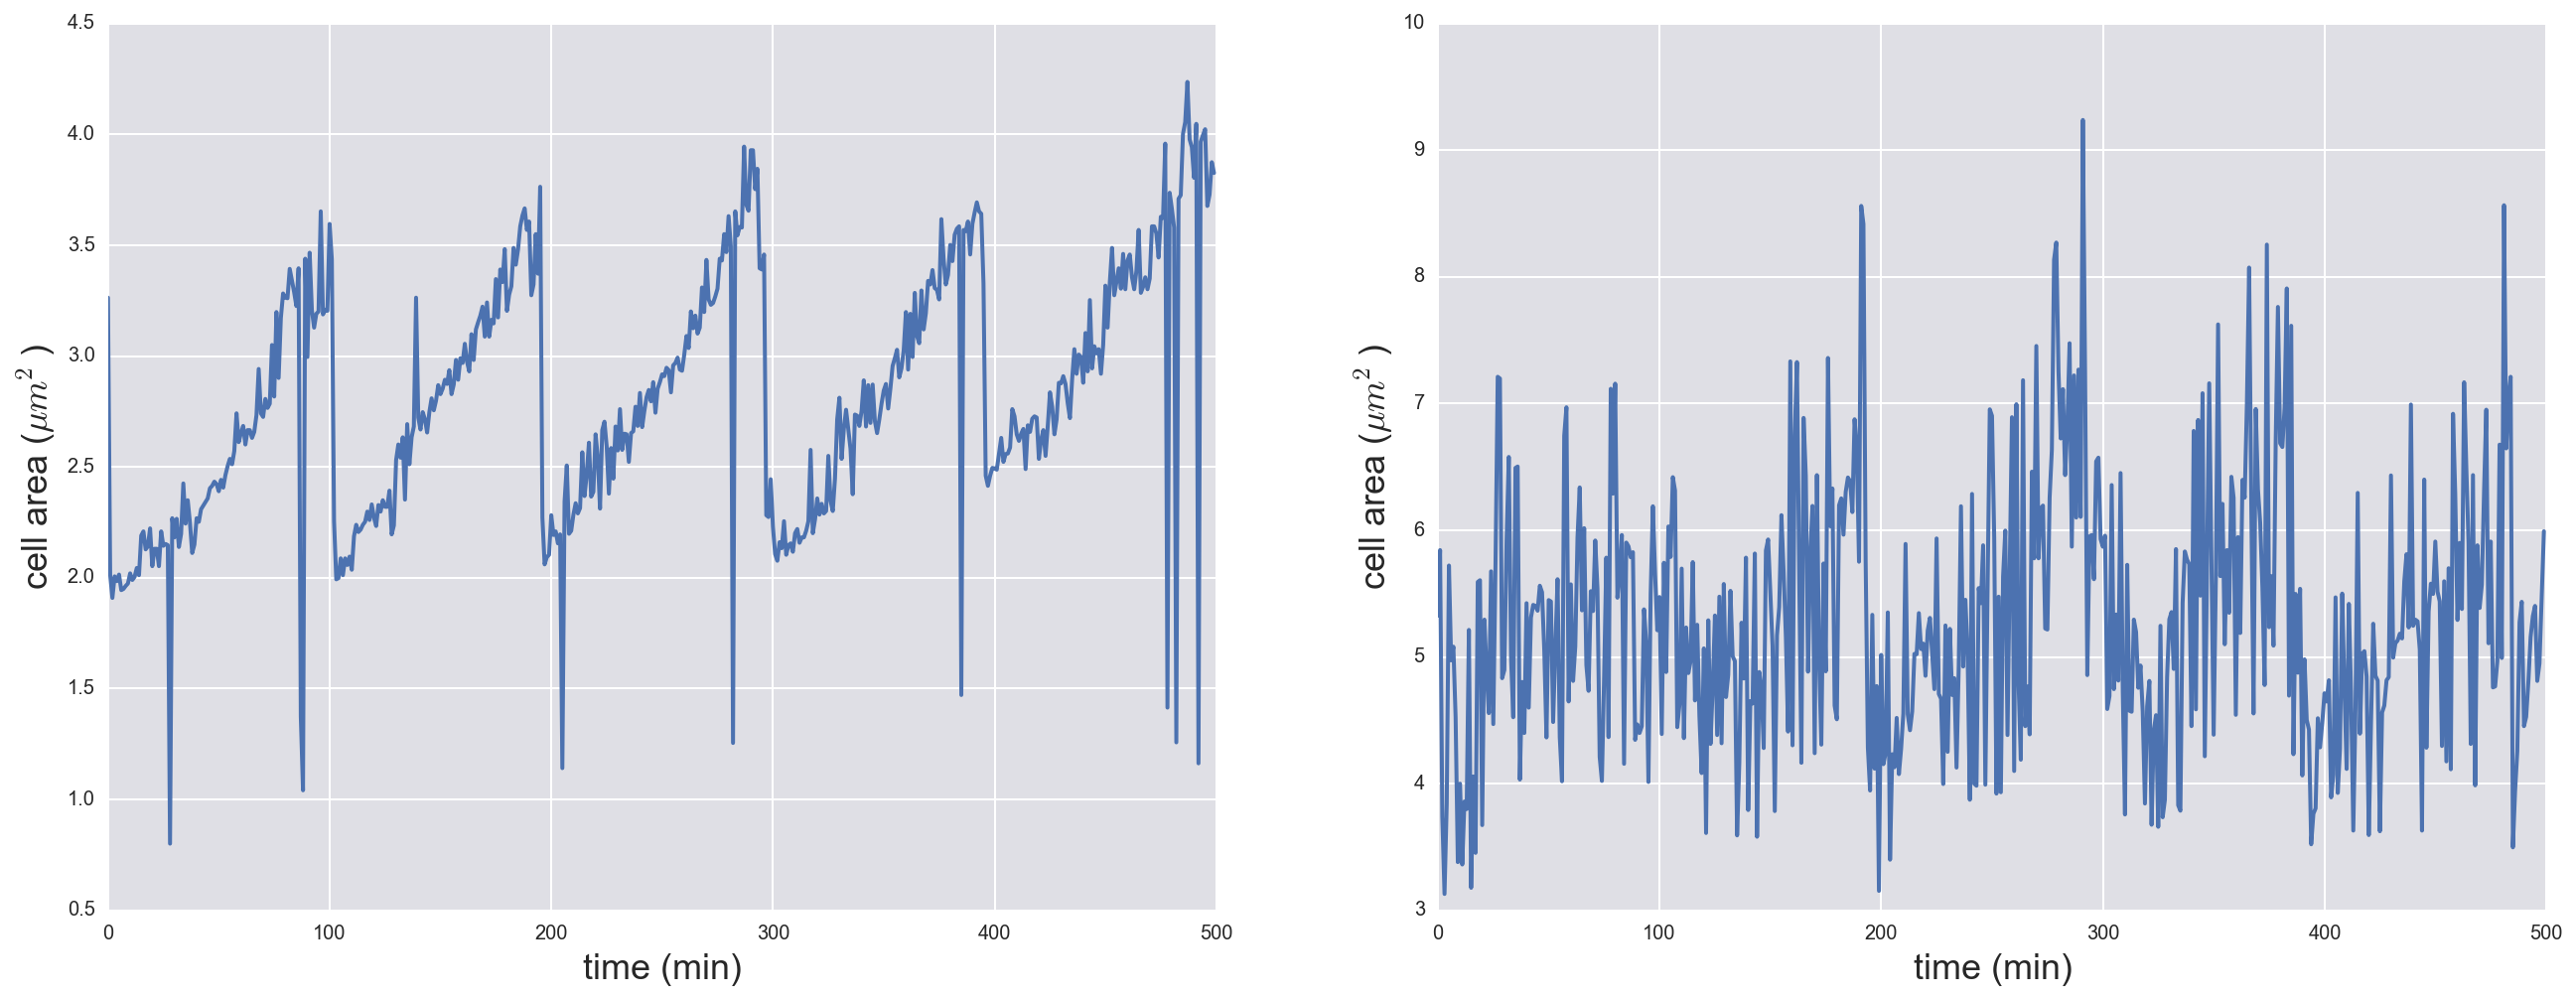

In [58]:
t1 = np.arange(0,g)
t2 = np.arange(0,q)
area1 = np.array(area1) * .052**2
area2 = np.array(area2) * .052**2
fig, ax = plt.subplots(1,2,figsize=(22,8))
ax[0].plot(t1[0:500], area1[0:500])
ax[0].set_xlabel('time (min)')
ax[0].set_ylabel('cell area ($\mu m ^ 2$)')
ax[1].plot(t2[0:500], area2[0:500])
ax[1].set_xlabel('time (min)')
ax[1].set_ylabel('cell area ($\mu m ^ 2$)')

Except for some random spikes (maybe caused by poor segmentation on those frames), these look decent. Let's look at these in the frequency domain. 

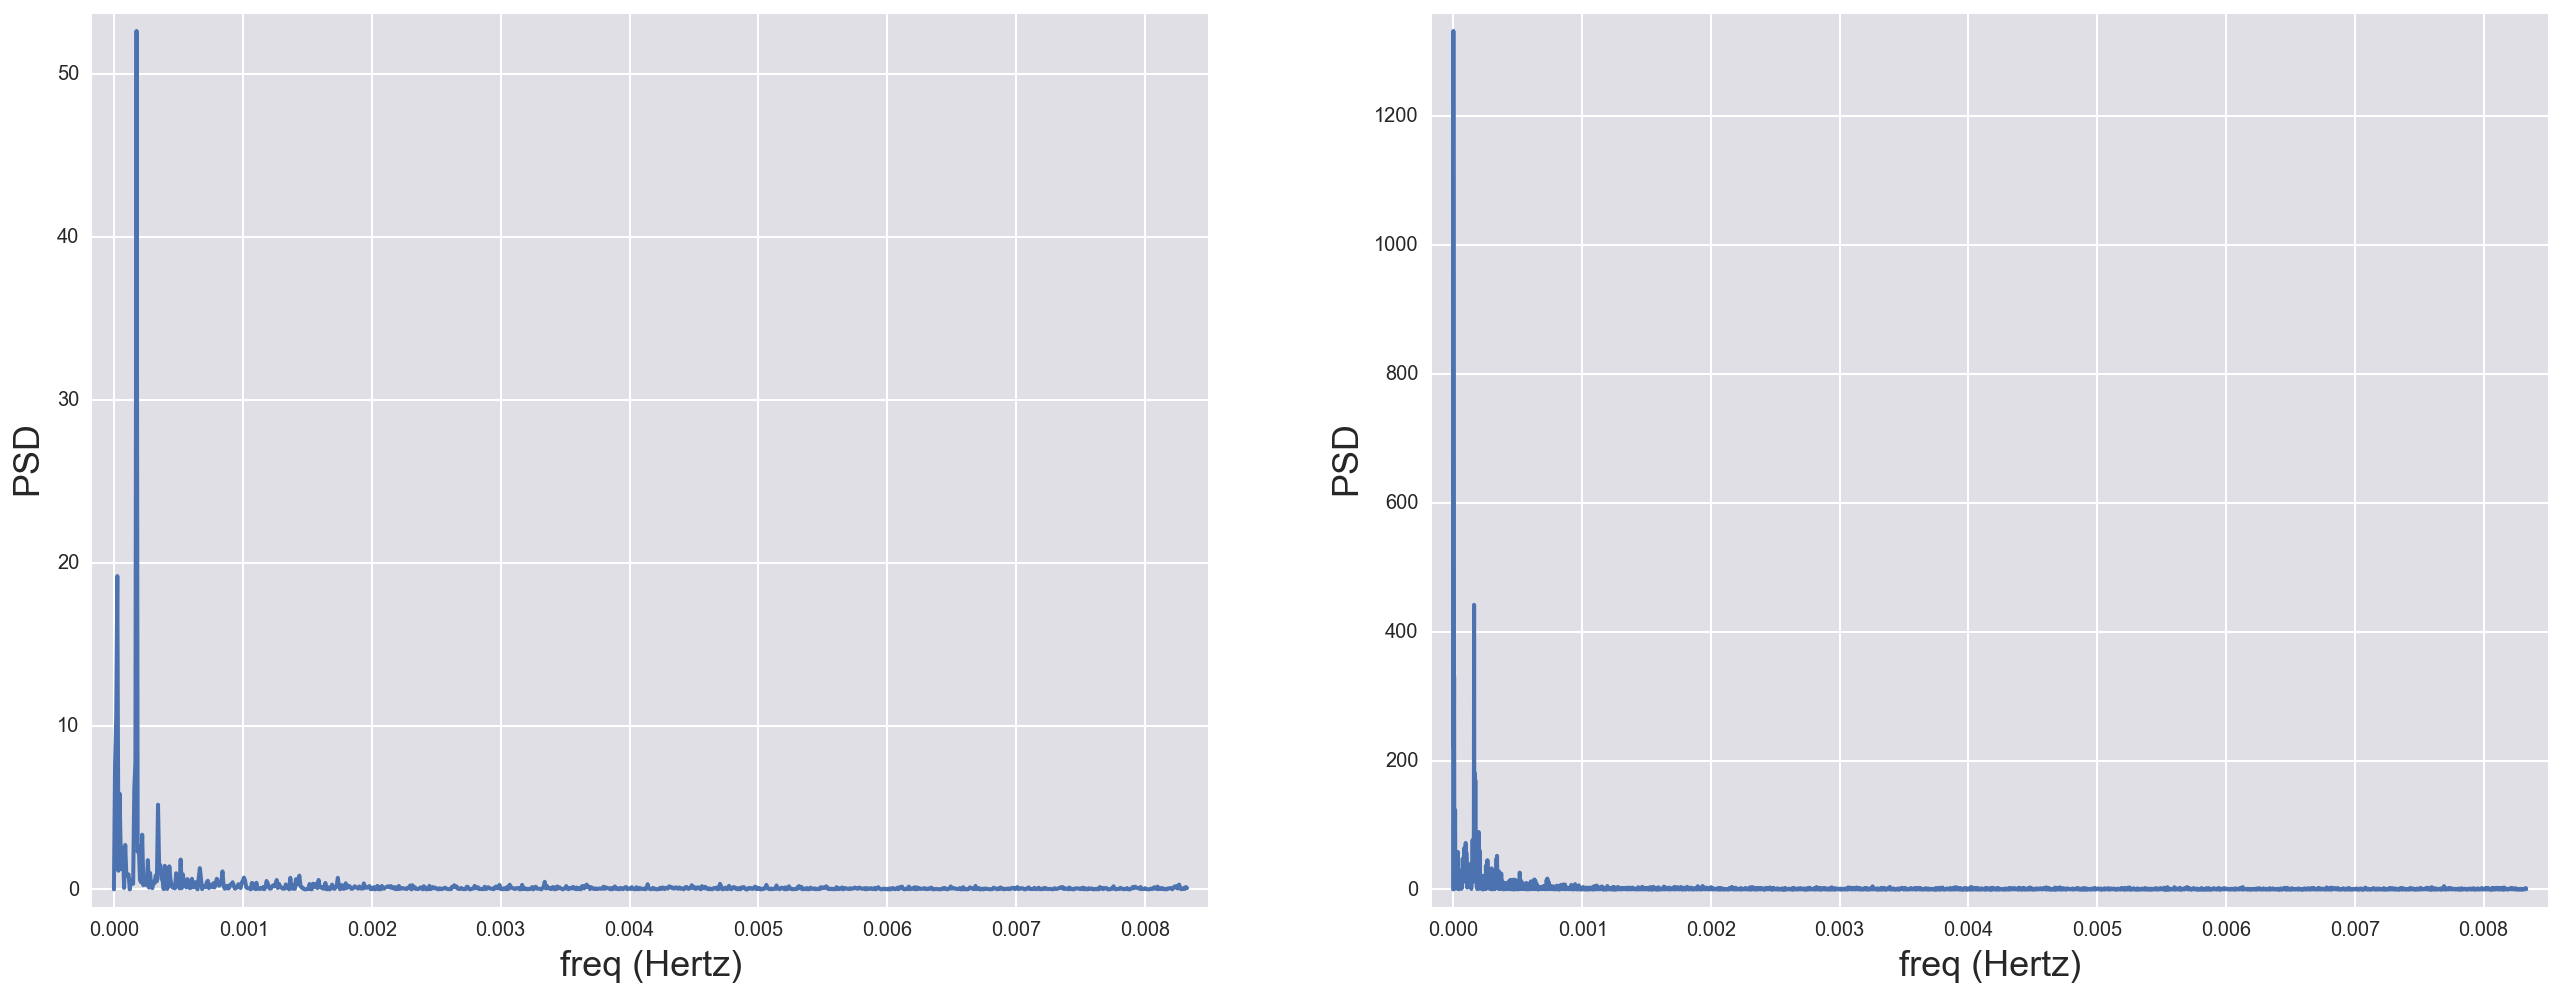

In [59]:
# Determine frequencies
sampling_freq = 1.0 / 60.0 # in Hertz
fig, ax = plt.subplots(1, 2, figsize=(22,8))
for i, a in enumerate([area1, area2]):
    f = np.fft.fftfreq(len(a)) * sampling_freq
    # Compute power spectral density
    psd = np.abs(np.fft.fft(a-np.mean(a)))**2 / len(a)
    ax[i].plot(f[f>=0], psd[f>=0])
    ax[i].set_ylabel('PSD')
    ax[i].set_xlabel('freq (Hertz)')
    ax[i].margins(.02)



It looks like there's an offset, but there are small amounts of high frequency noise that we can filter out to smooth things. The signal is at approximately 0.0017 Hz, so we should filter well above that. 

In [60]:
# Compute Nyquist frequency
nyquist_freq = sampling_freq / 2

# Design a butterworth filter
b, a = scipy.signal.butter(3, 0.0025 / nyquist_freq, btype='low')

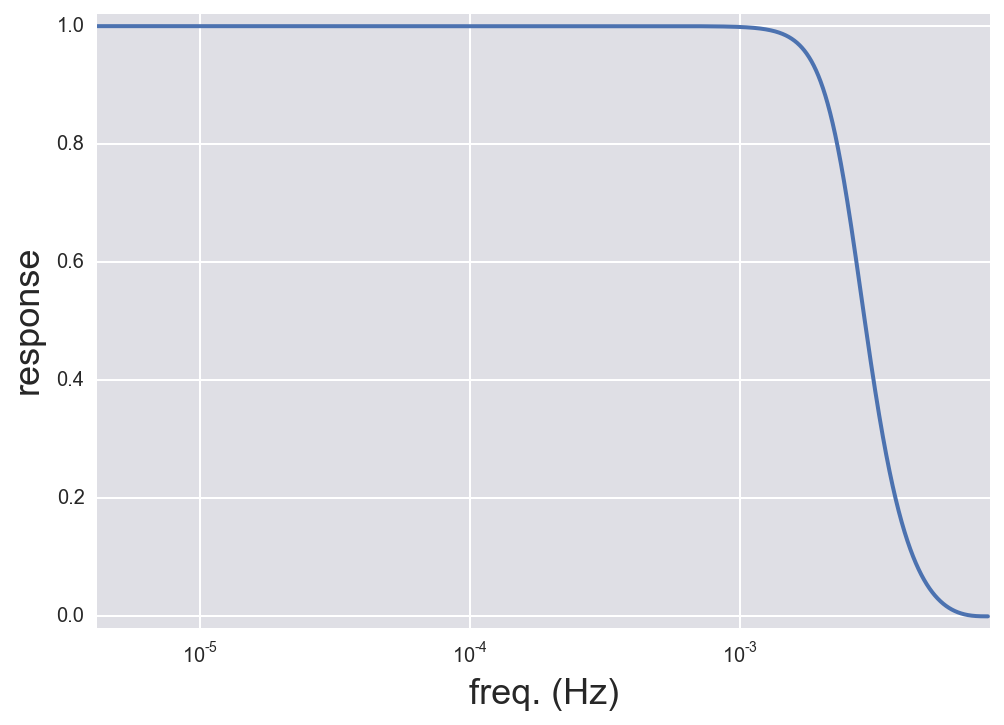

In [61]:
# Get frequency response curve
w, h = scipy.signal.freqz(b, a, worN=2000)

# Make plot
plt.semilogx((nyquist_freq / np.pi) * w, abs(h))
plt.xlabel('freq. (Hz)')
plt.ylabel('response')
plt.margins(0.02)

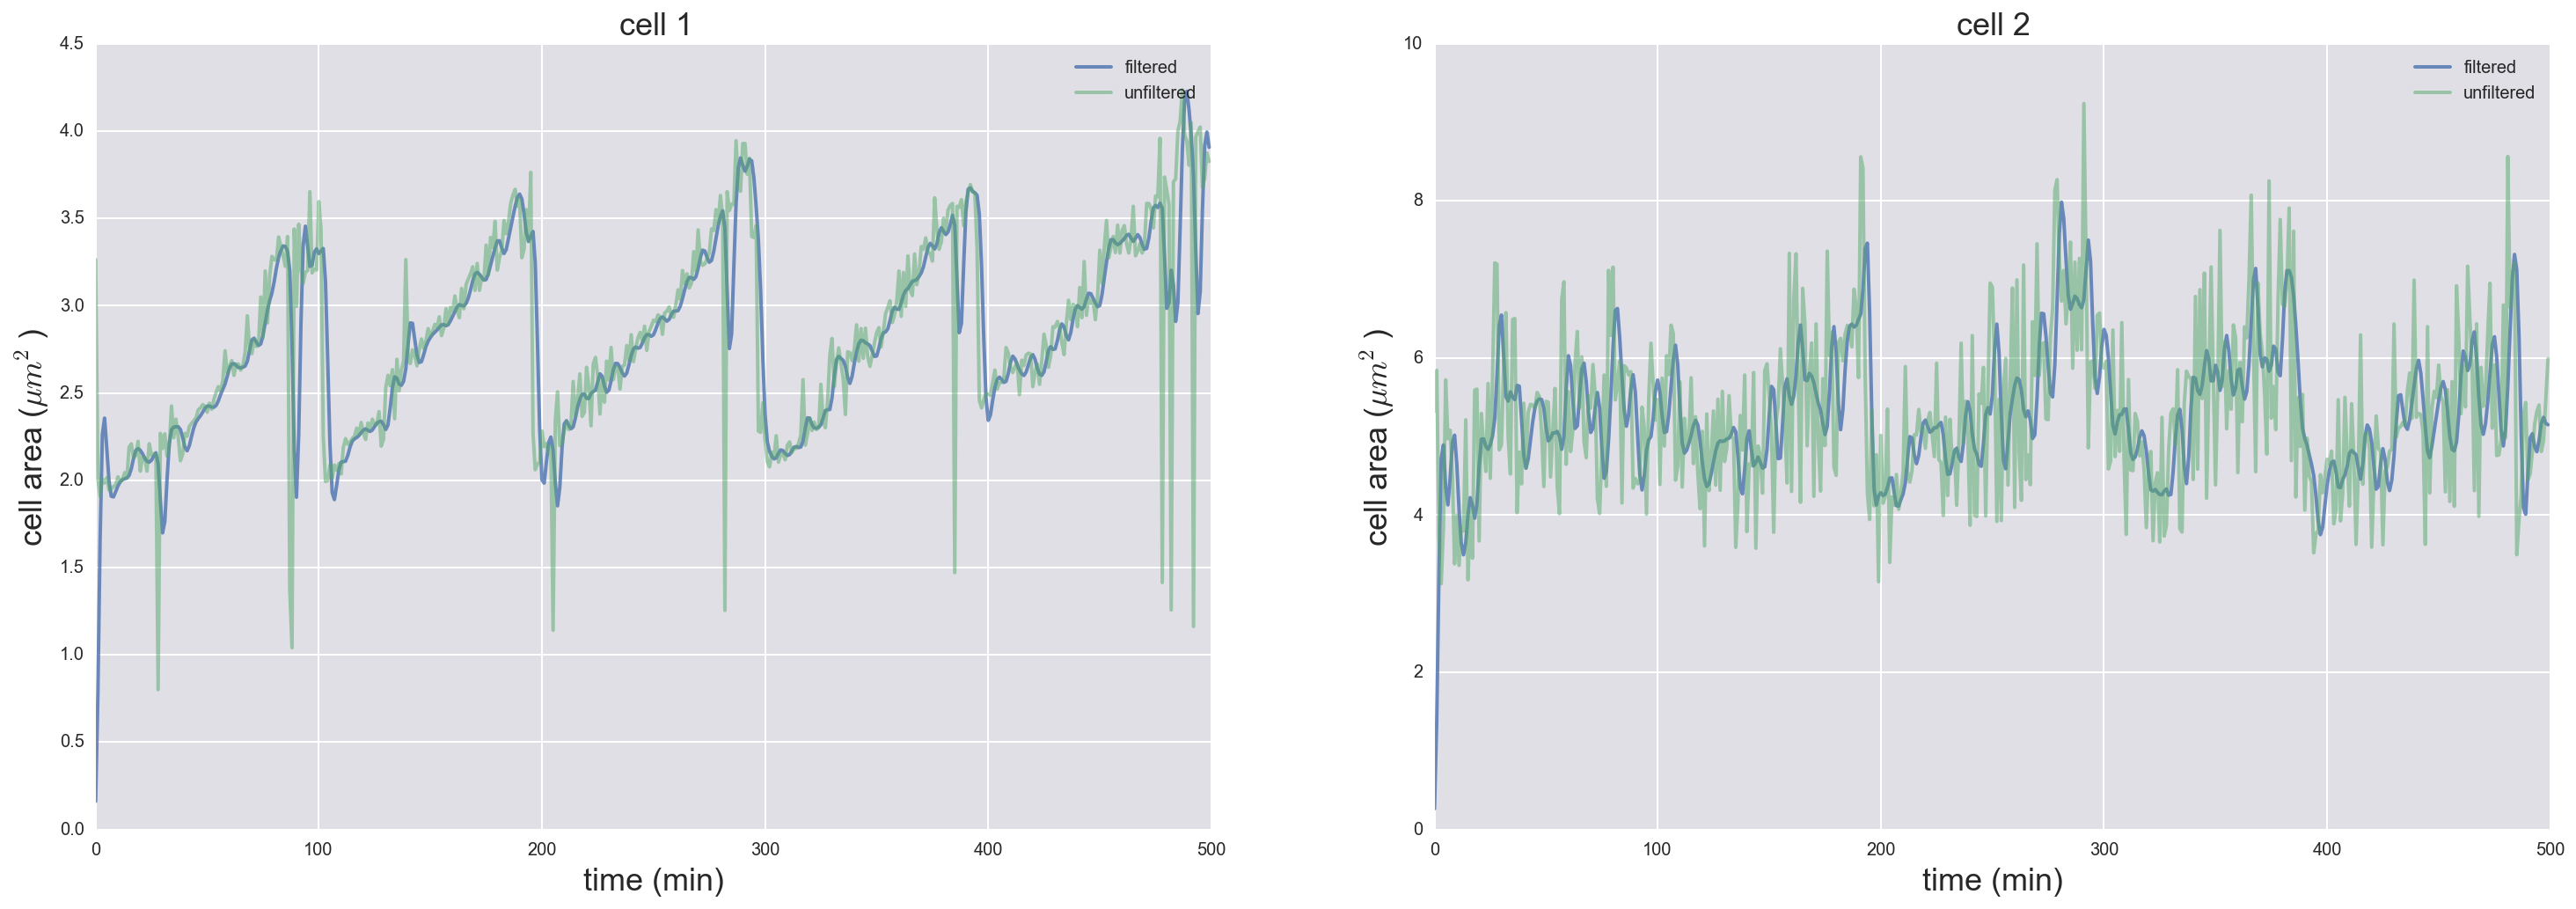

In [62]:
filtered1 = scipy.signal.lfilter(b, a, area1)
filtered2 = scipy.signal.lfilter(b, a, area2)

t_max = 500
fig, ax = plt.subplots(1, 2, figsize=(25,8))
areas = {0:area1, 1:area2}
filtered = {0:filtered1, 1:filtered2}
times = {0:t1, 1:t2}
for i in range(2):
    ax[i].plot(times[i][0:t_max], filtered[i][0:t_max], alpha=0.8)
    ax[i].plot(times[i][0:t_max], areas[i][0:t_max], alpha=0.5)
    ax[i].set_xlabel('time (min)')
    ax[i].set_ylabel('cell area ($\mu m ^ 2$)')
    ax[i].legend(['filtered', 'unfiltered'])
    ax[i].set_title('cell %d' %(i+1))


Now, we need to find where the daughter cells split off. To do that, let's begin by taking the derivative. 

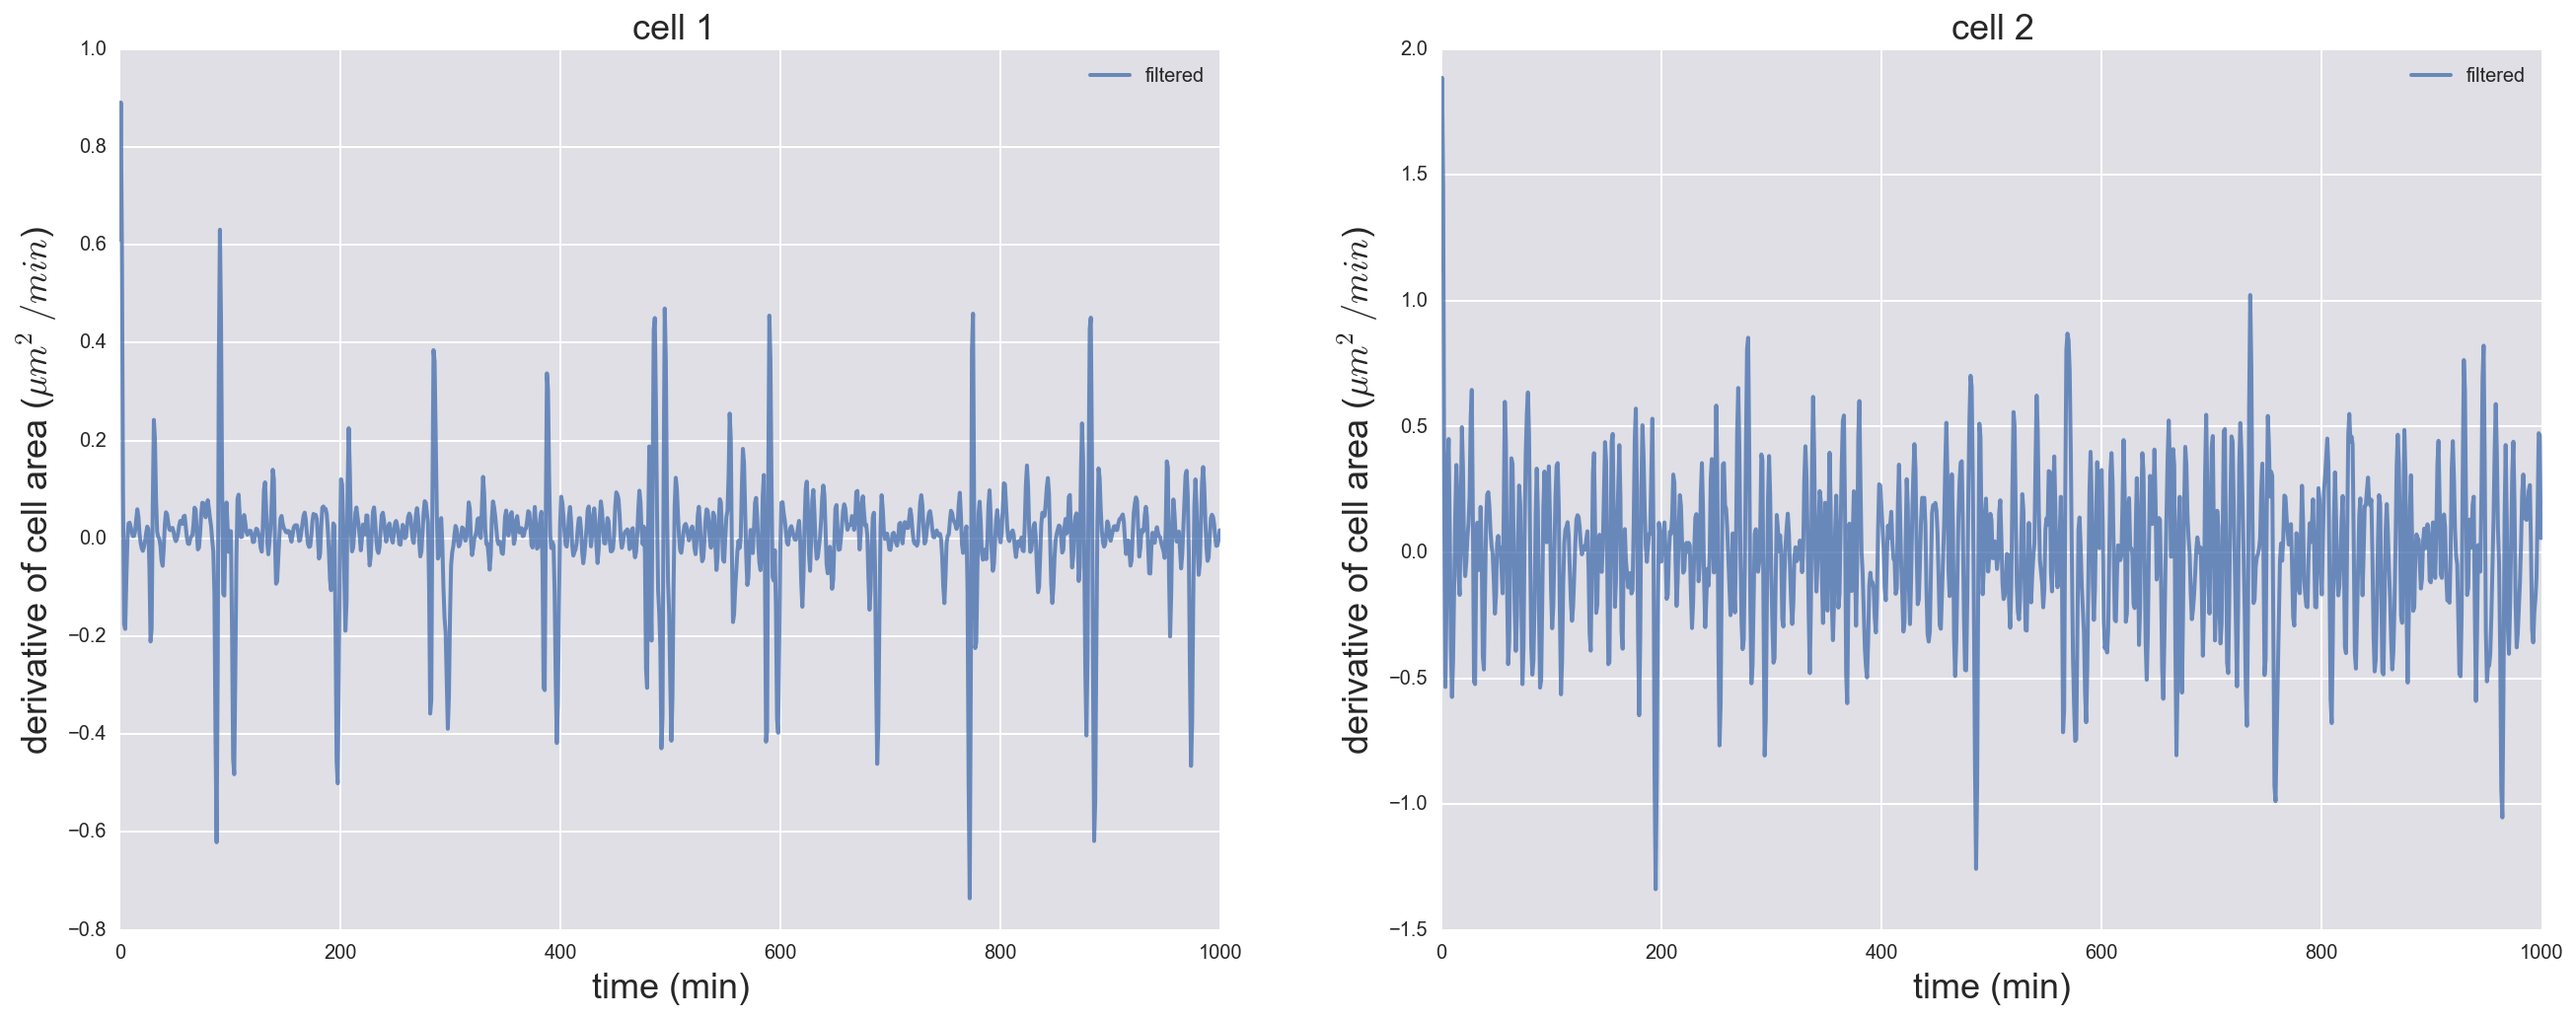

In [63]:
diffs = {}
diffs[0] = np.diff(filtered1)
diffs[1] = np.diff(filtered2)
fig, ax = plt.subplots(1, 2, figsize=(22,8))
t_max = 1000
for i in range(2):
    ax[i].plot(times[i][0:t_max], diffs[i][0:t_max], alpha=0.8)
    ax[i].set_xlabel('time (min)')
    ax[i].set_ylabel('derivative of cell area ($\mu m ^ 2/min$)')
    ax[i].legend(['filtered', 'unfiltered'])
    ax[i].set_title('cell %d' %(i+1))

It seems that we should be able to find the times where the cells split off by looking for times where the derivative is below a certain threshhold, with the limitation that at least $\tau$ time must have elapsed since the last split. Let's try setting $\tau$ to 85. For cell 1, we'll set the threshhold to -0.08, and for cell 2, we'll set it to -0.15. Also, where there are two spikes close together, we generally want the later one. The easiest way to do this is to traverse the list of derivative values backwards. 

In [64]:
def find_breaks(diff, threshhold, tau):
    breaks = [False for _ in range(len(diff))]
    last = np.inf
    for i, d in reversed(list(enumerate(diff))):
        if d < threshhold and last-i > tau:
            j = 0
            while True:
                if diff[i+j] > 0:
                    breaks[i+j] = True
                    last = i+j
                    break
                j += 1
    breaks = [j for j in range(len(breaks)) if breaks[j]]
    return breaks

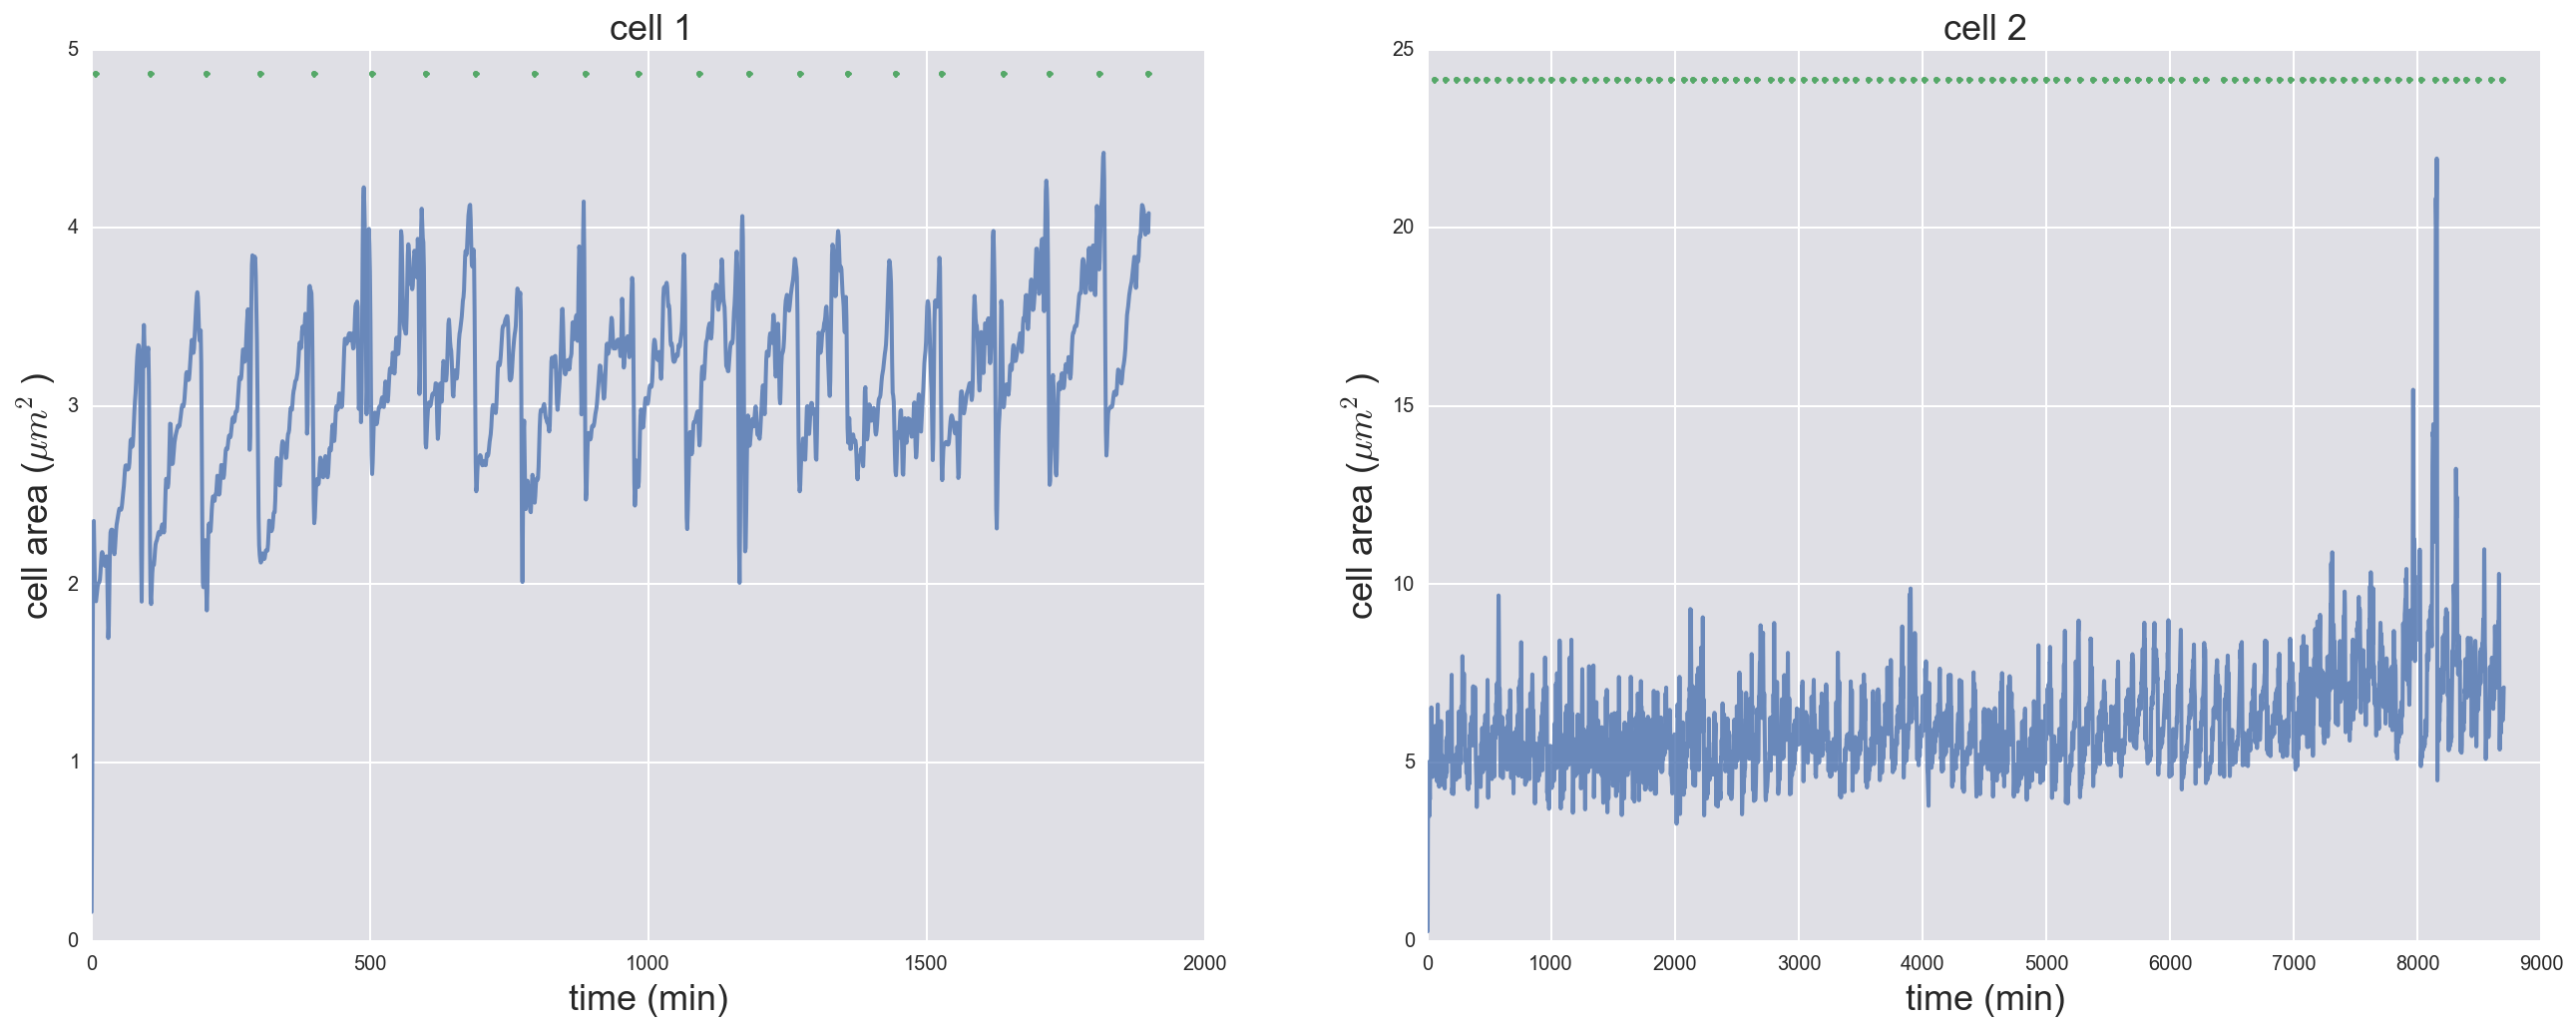

In [65]:
b1 = find_breaks(diffs[0], -0.05, 85)
b2 = find_breaks(diffs[1], -0.15, 85)
bs = {0:b1, 1:b2}
fig, ax = plt.subplots(1, 2, figsize=(22,8))
t_max = 1000
for i in range(2):
    t_max = len(times[i])
    ax[i].plot(times[i][0:t_max], filtered[i][0:t_max], alpha=0.8)
    plotted = [b for b in bs[i] if b < t_max]
    ax[i].plot(plotted, 
               [1.1*max(filtered[i][0:t_max]) for _ in range(len(plotted))],
               '.')
    ax[i].set_xlabel('time (min)')
    ax[i].set_ylabel('cell area ($\mu m ^ 2$)')
    ax[i].set_title('cell %d' %(i+1))

These divisions seem to line up pretty well with what we see by eye. Let's take each division and plot it on top of the others to get a better idea of how we're doing. 

In [66]:
def to_cycles(areas, breaks):
    cycles = []
    for i,b in enumerate(breaks[0:-2]):
        next_b = breaks[i+1]
        cycles.append(areas[b:next_b])      
    return cycles

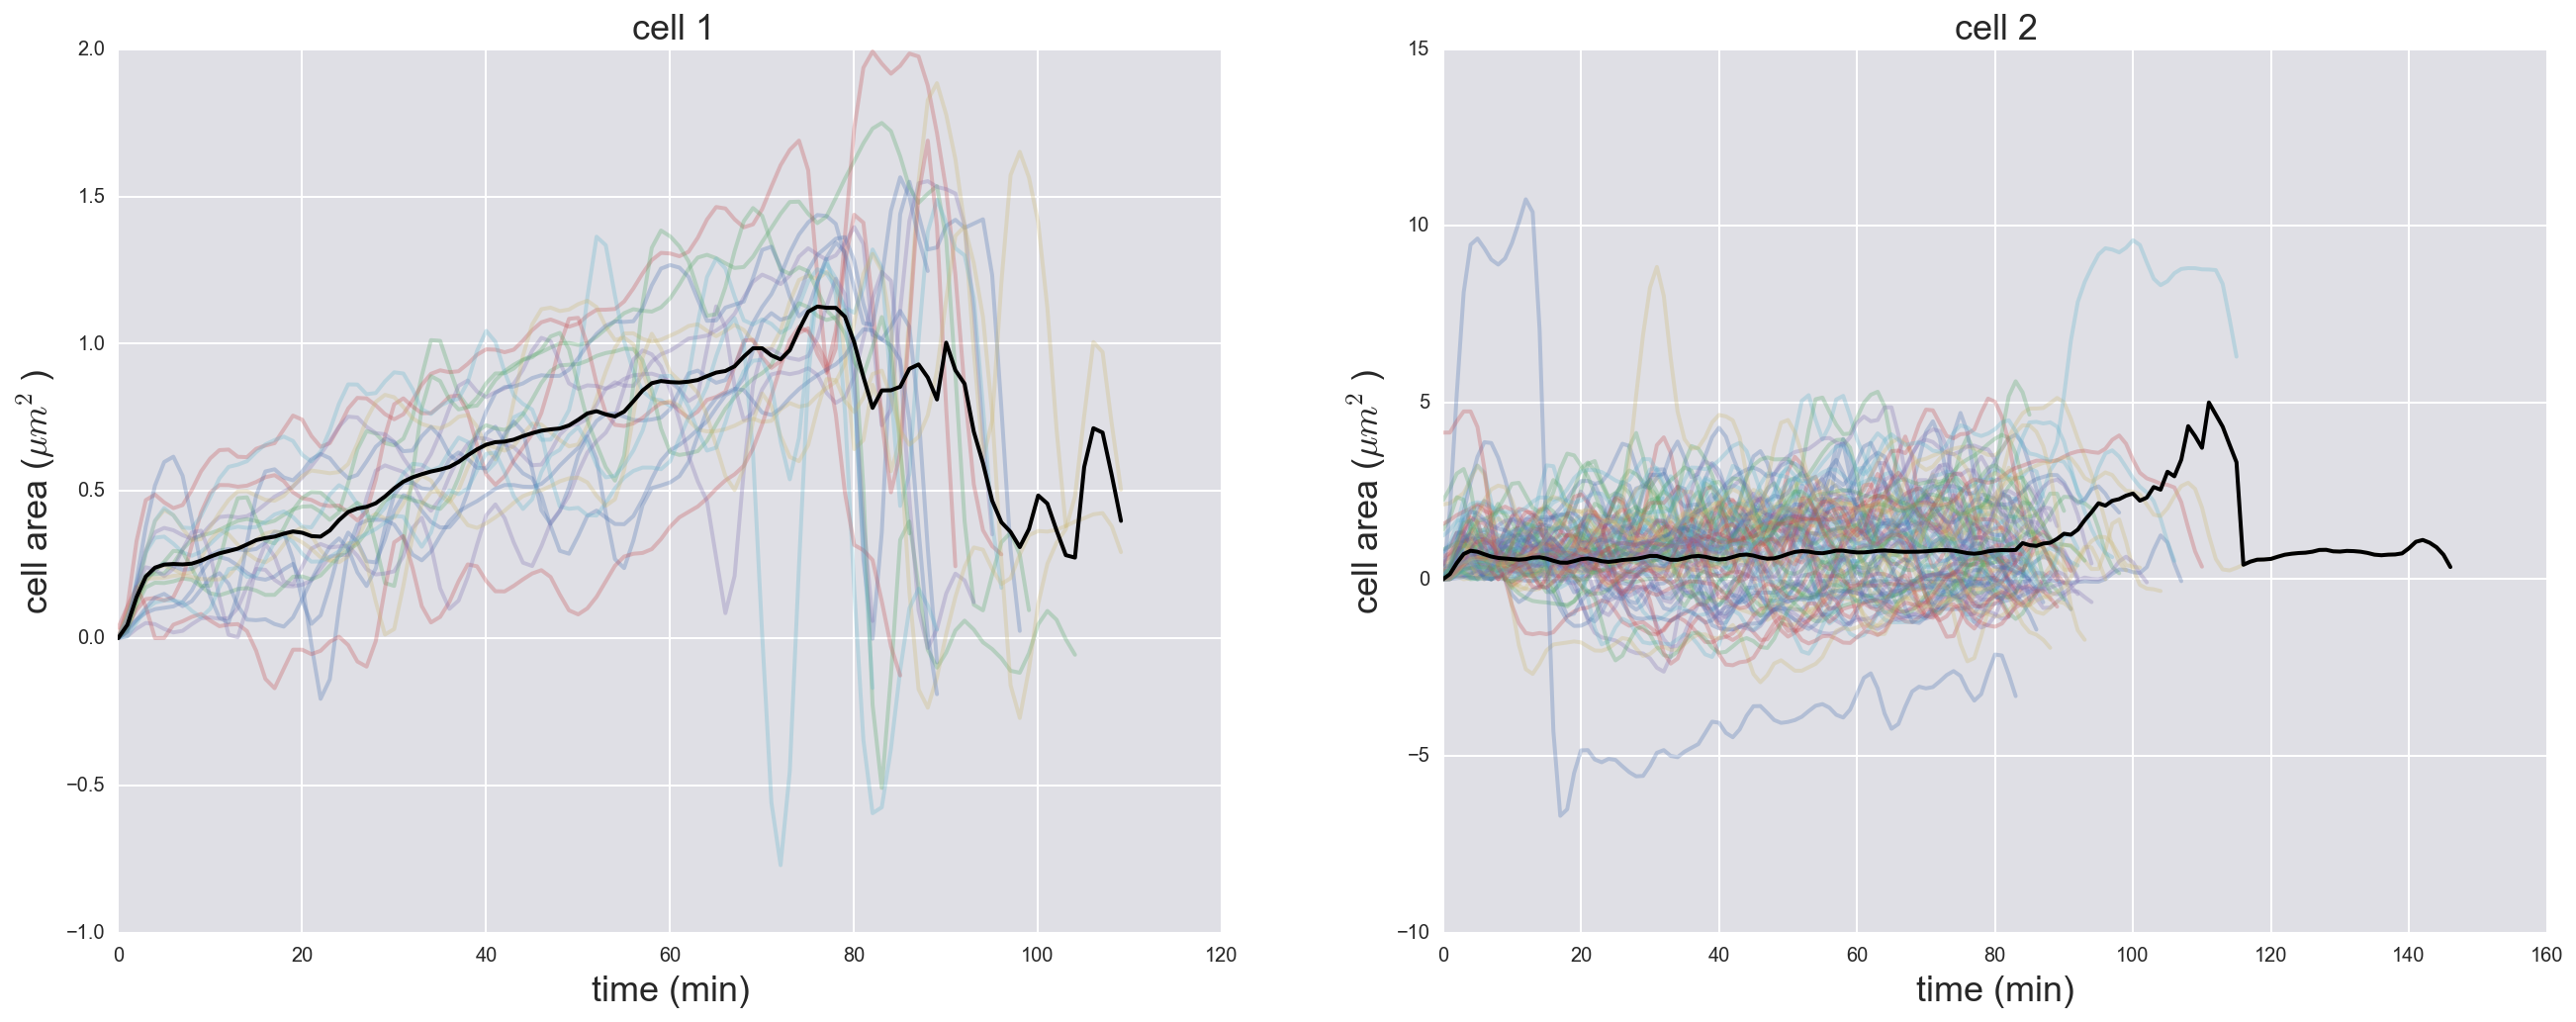

In [67]:
cycles = {}
cycles[0] = to_cycles(filtered[0], bs[0])
cycles[1] = to_cycles(filtered[1], bs[1])
fig, ax = plt.subplots(1, 2, figsize=(22,8))
for i in range(2):
    for c in cycles[i]:
        ax[i].plot((range(len(c))), np.array(c)-min(c[0:10]), alpha=0.3)
    df = pd.DataFrame([np.array(c) - c[0] for c in cycles[i]])
    ax[i].plot(df.mean(axis=0), color='black')
    ax[i].set_xlabel('time (min)')
    ax[i].set_ylabel('cell area ($\mu m ^ 2$)')
    ax[i].set_title('cell %d' %(i+1))


There are still a lot of spikes, even after the low-pass filter. Let's try just finding them and deleting them. To start, let's put the filtered cell areas and their derivatives into a DataFrame. 

In [68]:
df1 = pd.DataFrame([np.array(c) for c in cycles[0]])
df1 = df1.T
for c in df1.columns:
    df1['d'+str(c)] = np.append(np.diff(df1[c]), float('nan'))
df1['t (min)'] = [i for i in np.arange(len(df1))]

df2 = pd.DataFrame([np.array(c) for c in cycles[1]])
df2 = df2.T
for c in df2.columns:
    df2['d'+str(c)] = np.append(np.diff(df2[c]), float('nan'))
df2['t (min)'] = [i for i in np.arange(len(df2))]


Next, let's replace the values inside 'spikes' with NaN. After about 80 minutes, things also get pretty messy, let's cut those off as well.  

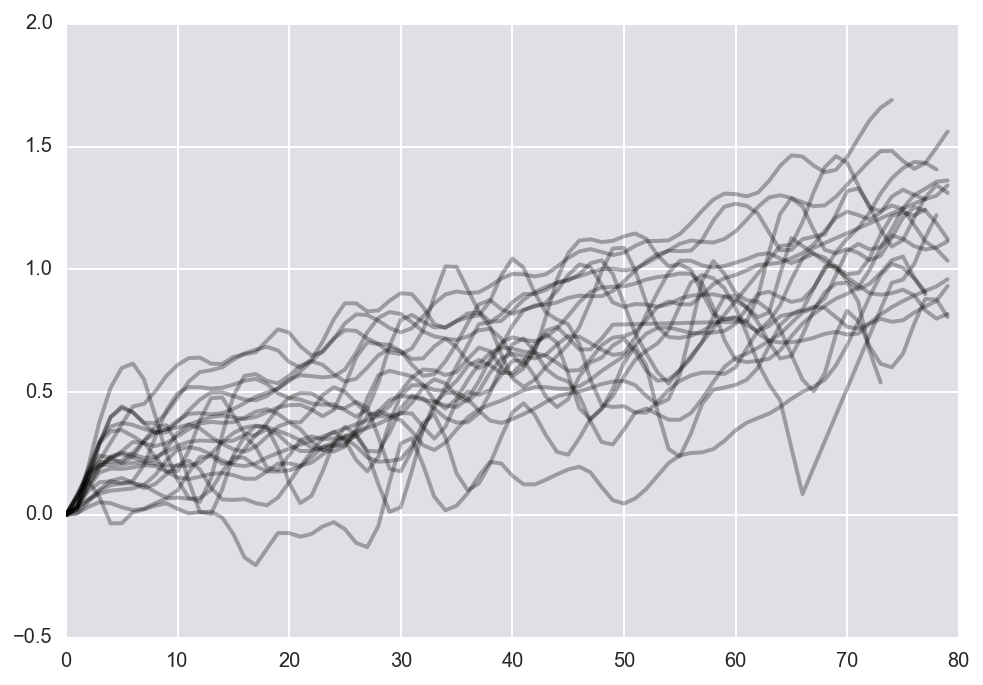

In [69]:
threshold = 0.2
for c in df1.columns:
    if type(c) is not int:
        continue
    in_spike = 0
    switched = 0
    for i,d in enumerate(df1['d'+str(c)]):
        if in_spike == 0 and d > threshold:
            in_spike = 1
        elif in_spike == 0 and d < -threshold:
            in_spike = -1
        elif in_spike != 0 and in_spike*d < 0:
            switched = 1
        elif switched == 1 and abs(d) < threshold:
            switched = 0
            in_spike = 0
        if in_spike != 0:
            df1.loc[i, c] = float('nan')
    inds = ~pd.isnull(df1[c]) 
    inds2 = df1['t (min)'] < 80
    inds = pd.Series([i and j for i,j in zip(inds, inds2)],index=df1.index)
    plt.plot(df1[inds]['t (min)'], 
             df1[inds][c]-df1[inds].loc[0,c], 
             color='black',
             alpha=0.3)          

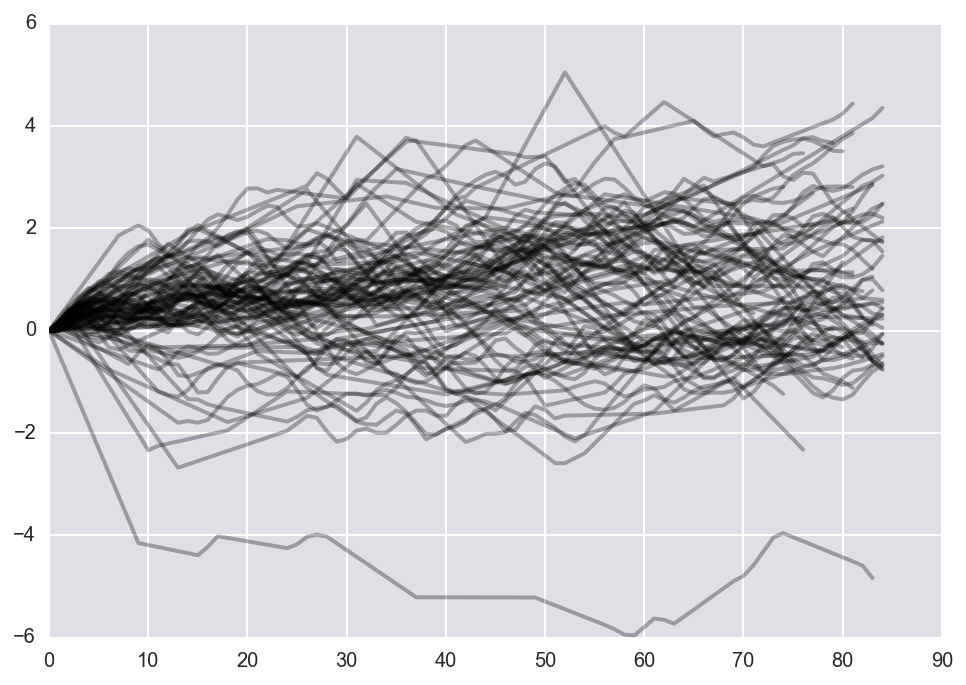

In [70]:
threshold = 0.3
for c in df2.columns:
    if type(c) is not int:
        continue
    in_spike = 0
    switched = 0
    for i,d in enumerate(df2['d'+str(c)]):
        if in_spike == 0 and d > threshold:
            in_spike = 1
        elif in_spike == 0 and d < -threshold:
            in_spike = -1
        elif in_spike != 0 and in_spike*d < 0:
            switched = 1
        elif switched == 1 and abs(d) < threshold:
            switched = 0
            in_spike = 0
        if in_spike != 0:
            df2.loc[i, c] = float('nan')
    inds = ~pd.isnull(df2[c]) 
    inds2 = df2['t (min)'] < 85
    inds = pd.Series([i and j for i,j in zip(inds, inds2)],index=df2.index)
    try:
        plt.plot(df2[inds]['t (min)'], 
             df2[inds][c]-df2[inds].loc[0,c], 
             color='black',
             alpha=0.3)   
    except:
        pass

This one has a few traces that are just weird, but the majority look ok. 

In principle, the best way to do this would be a three-level heirarchical model. The lowest level would be the model parameters $\theta$, which are calculated for each cycle. The cycles are then grouped by the cell in question, and so $\theta$ is dependent on a set of hyperparameters $\phi$. These correspond to the 'true' parameter values for each cell. These in turn are dependent on a second set of hyperparameters $\psi$, which are the 'globally true' parameter values. The general posterior for a three-level heirarchical model is:

$$
    P(\theta, \phi, \psi|D,I) = \frac{P(D|\theta,I) P(\theta|\phi,I) P(\phi|\psi,I)     P(\psi|I)} {P(D|I)}
$$

We can assume a Gaussian likelihood dependent on the model in question. We can also assume Gaussian distributions for the conditional portions of the prior, and then some non-informative prior on the true values $\psi$. 

Unfortunately, there is not enough time to run a PT-MCMC on this model, with its hundreds of parameters, and so we need something simpler. To begin, let's assume that the value of $a_0$ is not very interesting. In both the linear and exponential models, it is simply the area of the cell at time 0. This varies between cycles, but is not what distinguishes the models. What we can do then, is to pool the data for each of the two cells. We then normalize each cycle so that it's $a(0) = 1$ when using the exponential model and $a(0) = 0$ when using the linear model. After that, within the cycles for each cell, we'll consider each normalized (t, a) measurement independently of which cycle it came from. We will consider the two cells separately. 

First, let's get these tidy dataframes of normalized (t, a) measurements. 

In [71]:
df1_exp = []
df1_lin = []
for c in df1.columns:
    if type(c) is not int:
        continue
    norm = df1[c].loc[0]
    for i,a in enumerate(df1[c]):
        if np.isnan(a):
            continue
        df1_exp.append([i,a/norm])
        df1_lin.append([i,a-norm])
df1_exp = pd.DataFrame(df1_exp, columns=['time', 'area'])
df1_lin = pd.DataFrame(df1_lin, columns=['time', 'area'])

Now, let's define log likelihoods. For a model $a = M(t,\theta)$ with $n$ measurements:

$$
    P(D|\theta, \sigma, I) = \prod_{i=1}^{n}\frac{1}{\sqrt{2\pi \sigma^2}} 
    \text{exp}\left[ 
    -\frac{\left(M(t_i,\theta) - a_i\right)^2}{2\sigma^2}
    \right]
$$

$$
    \text{log} P(D|\theta, \sigma, I) = -n\text{log}\sqrt{2\pi\sigma^2} - 
    \frac{1}{2\sigma^2}\sum_{i=1}^{n}\left[M(t_i,\theta) - a_i\right]^2
$$

In [72]:
def log_likelihood (params, times, areas, func):
    b, sigma = params
    if sigma < 0:
        return -np.inf
    predicted = func(b, times)
    n = len(times)
    return -n * np.log(np.sqrt(2*np.pi*sigma**2)) \
        - np.sum((areas-predicted)**2) / 2 / sigma**2
    
def linear(b, times):
    return b*times

def exponential (b, times):
    return np.exp(b*times)

Now, let's do the priors. For ease of normalization, we're going to define both the parameter ($b$) and $\sigma$ to have uniform priors. 

In [73]:
def log_prior (params):
    b, sigma = params
    b_max = 1.5
    sigma_max = 10.0
    if b < 0 or b > b_max or sigma < 0 or sigma > sigma_max:
        return -np.inf
    else:
        return -np.log(b_max + sigma_max)